In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from itertools import combinations
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.inspection import PartialDependenceDisplay

# 1. Define KRLS

In [2]:
def gaussian_kernel(X1, X2, sigma):
    """
    Compute the Gaussian (RBF) kernel matrix using scikit-learn's rbf_kernel.
    :param X1: Data matrix A (n_samples_A, n_features), can be a DataFrame or ndarray
    :param X2: Data matrix B (n_samples_B, n_features), can be a DataFrame or ndarray
    :param sigma: Bandwidth of the Gaussian kernel
    :return: Gaussian kernel matrix
    """
    if isinstance(X1, (pd.DataFrame, pd.Series)):
        X1 = X1.values
    if isinstance(X2, (pd.DataFrame, pd.Series)):
        X2 = X2.values

    gamma = 1.0 / (2 * sigma**2)
    return rbf_kernel(X1, X2, gamma=gamma)

In [3]:
"""
Construct KRLS algorithm
hyperparameter: sigma, alpha
"""

class KRLS(BaseEstimator, RegressorMixin):
    def __init__(self, sigma=1.0, alpha=1.0):
        """
        Initialize KRLS
        :param sigma: width of kernel
        :param alpha: regularized parameter
        """
        self.sigma = sigma
        self.alpha = alpha
    
    def fit(self, X, y):
        """
        Train KRLS model
        :param X: training data (n_samples, n_features)
        :param y: observed value (n_samples,)
        """
        self.X_train = X
        K = gaussian_kernel(X, X, self.sigma)
        self.alpha_ = np.linalg.inv(K + self.alpha * np.eye(K.shape[0])).dot(y)
        return self
    
    def predict(self, X):
        """
        Use fitted KRLS model to predict
        :param X: testing data (n_samples, n_features)
        :return: predicted value
        """
        K = gaussian_kernel(X, self.X_train, self.sigma)
        return K.dot(self.alpha_)
    
    def get_params(self, deep=True):
        """
        Get parameters of KRLS model
        """
        return {"sigma": self.sigma, "alpha": self.alpha}
    
    def set_params(self, **parameters):
        """
        Set parameters of KRLS model
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# 2. Use KRLS to make basic analysis

In [4]:
# Read data
Regression_data_month = pd.read_csv('./Regression_month_new.csv')

In [5]:
Regression_data_month.describe()

,Unnamed: 0,gvkey,month,RET%,fyear,log_scope_1,log_scope_2,Winsorised Growth Rate in Carbon Emissions Scope 1,Winsorised Growth Rate in Carbon Emissions Scope 2,Winsorised Carbon Intensity Scope 1,...,Winsorised BM,Winsorised Leverage,Winsorised INVESTA,Winsorised ROE,LOGPPE,Winsorised SALESGR,MOM_duplicate,beta,VOLAT,EPSGR
count,385419.000000,385419.000000,385419.000000,385419.000000,385419.000000,231039.000000,231064.000000,203232.000000,203232.000000,226999.000000,...,218208.000000,230520.000000,230590.000000,230932.000000,185867.000000,202652.000000,337880.000000,362377.000000,48965.000000,230943.000000
mean,192709.000000,54845.903910,6.554573,0.982939,2016.456693,10.196407,10.469592,0.063291,0.083948,1.263314,...,0.546065,0.270907,0.029647,7.711958,7.268571,0.090334,0.135931,1.105152,0.114619,0.025154
std,111261.026038,64289.213484,3.438300,11.314887,3.588310,3.124783,2.718884,0.370854,0.413537,4.693970,...,0.434432,0.202770,0.036277,41.596463,2.336983,1.797808,0.478318,0.625873,0.157452,1.784203
min,0.000000,1004.000000,1.000000,-46.052632,2010.000000,-1.645065,-0.079043,-0.766253,-0.676186,0.002459,...,-0.218942,0.000000,0.000000,-240.205070,-2.465104,-0.749541,-0.888750,-0.171023,0.023020,-7.513988
25%,96354.500000,10086.000000,4.000000,-4.822899,2013.000000,8.036567,8.764322,-0.060508,-0.062660,0.039278,...,0.255590,0.104167,0.003787,3.655294,5.711029,-0.008758,-0.123426,0.695100,0.060661,-0.550468
50%,192709.000000,23083.000000,7.000000,0.772200,2017.000000,10.186898,10.688325,0.000253,0.000000,0.130756,...,0.429435,0.249756,0.018633,9.838676,7.356216,0.033179,0.074738,1.055753,0.085914,-0.015109
75%,289063.500000,66366.000000,10.000000,6.319703,2019.000000,12.666913,12.793022,0.106248,0.132487,0.295027,...,0.762309,0.395625,0.039741,18.272460,9.078945,0.114588,0.298988,1.444517,0.126845,0.423139
max,385418.000000,328795.000000,12.000000,69.826889,2022.000000,18.804073,16.920606,2.102875,2.270040,34.648542,...,2.344154,0.904107,0.203190,186.515669,13.144907,225.869455,4.711340,2.832603,2.681848,12.620800


In [6]:
# sort the dataframe
Regression_data_month = Regression_data_month.sort_values(by=['gvkey', 'fyear', 'month'])

columns_to_shift = ['LOGSIZE', 'Winsorised BM', 'Winsorised Leverage', 'Winsorised INVESTA', 
                    'Winsorised ROE', 'LOGPPE', 'MOM_duplicate', 'beta', 'VOLAT', 'Winsorised SALESGR', 'EPSGR']

# define the shift function
def shift_if_consecutive(group):
    group['year_month'] = pd.to_datetime(group['fyear'].astype(str) + '-' + group['month'].astype(str))
    group = group.sort_values(by='year_month')
    
    # Check continuity
    group['consecutive'] = group['year_month'].diff().dt.days <= 31
    
    # Shift
    for col in columns_to_shift:
        group[f'{col}_t-1'] = group[col].shift(1)
        # keep origin
        group[f'{col}_t-1'] = group.apply(lambda row: row[col] if not row['consecutive'] else row[f'{col}_t-1'], axis=1)
    
    return group.drop(columns=['consecutive', 'year_month'])

# Apply the function
Regression_data_month_shifted = Regression_data_month.groupby('gvkey', group_keys=False).apply(shift_if_consecutive)

# Remove duplicates
Regression_data_month_shifted = Regression_data_month_shifted.drop_duplicates()

# Reset the index
Regression_data_month_shifted.reset_index(drop=True, inplace=True)

# output
print(Regression_data_month_shifted.head())
print(f"Original data size: {Regression_data_month.shape}")
print(f"Shifted data size: {Regression_data_month_shifted.shape}")

   Unnamed: 0  gvkey       eow_x  month       RET%  fyear  log_scope_1  \
0      136963   1004  2010-02-28      2  -2.114804   2010          NaN   
1      328584   1004  2010-03-31      3  10.229277   2010          NaN   
2      130763   1004  2010-04-30      4  -2.480000   2010          NaN   
3       13841   1004  2010-05-31      5 -19.196062   2010          NaN   
4       58188   1004  2010-06-30      6  -8.527919   2010          NaN   

   log_scope_2  Winsorised Growth Rate in Carbon Emissions Scope 1  \
0          NaN                                                NaN    
1          NaN                                                NaN    
2          NaN                                                NaN    
3          NaN                                                NaN    
4          NaN                                                NaN    

   Winsorised Growth Rate in Carbon Emissions Scope 2  ...  Winsorised BM_t-1  \
0                                                NaN 

In [7]:
# Check and deal with unnormal values
Regression_data_month_shifted = Regression_data_month_shifted.replace([np.inf, -np.inf], np.nan) # change inf to NaN

In [8]:
subset = ['RET%', 'log_scope_1',
       'log_scope_2', 'Winsorised Growth Rate in Carbon Emissions Scope 1',
       'Winsorised Growth Rate in Carbon Emissions Scope 2',
       'Winsorised Carbon Intensity Scope 1',
       'Winsorised Carbon Intensity Scope 2', 'LOGSIZE_t-1',
       'Winsorised BM_t-1', 'Winsorised Leverage_t-1',
       'Winsorised INVESTA_t-1', 'Winsorised ROE_t-1', 'LOGPPE_t-1', 'MOM_duplicate_t-1', 'beta_t-1', 'VOLAT_t-1', 'Winsorised SALESGR_t-1', 'EPSGR_t-1']
Regression_data_1 = Regression_data_month_shifted.dropna(subset=subset)
sample_fraction = 0.7

In [9]:
Regression_data_1.describe()

,Unnamed: 0,gvkey,month,RET%,fyear,log_scope_1,log_scope_2,Winsorised Growth Rate in Carbon Emissions Scope 1,Winsorised Growth Rate in Carbon Emissions Scope 2,Winsorised Carbon Intensity Scope 1,...,Winsorised BM_t-1,Winsorised Leverage_t-1,Winsorised INVESTA_t-1,Winsorised ROE_t-1,LOGPPE_t-1,MOM_duplicate_t-1,beta_t-1,VOLAT_t-1,Winsorised SALESGR_t-1,EPSGR_t-1
count,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,...,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000
mean,175297.586146,44219.811447,6.756098,-0.625618,2017.114407,11.268829,11.350579,0.065423,0.085460,1.357575,...,0.455131,0.296283,0.034397,9.928818,7.591746,0.146361,1.148118,0.091276,0.070841,0.020111
std,105769.131777,60044.188201,3.212574,9.798059,2.277567,2.716611,2.170061,0.374495,0.381666,4.923266,...,0.402146,0.193952,0.032738,43.291002,2.212964,0.397591,0.608428,0.055748,0.481156,1.763968
min,38.000000,1004.000000,1.000000,-45.584726,2011.000000,0.693147,2.544276,-0.766253,-0.676186,0.002459,...,-0.218942,0.000000,0.000000,-240.205070,-2.465104,-0.879796,-0.171023,0.023020,-0.749541,-7.456088
25%,81412.000000,6310.000000,4.000000,-6.049448,2015.000000,9.352081,9.766575,-0.057777,-0.055420,0.046301,...,0.210205,0.153574,0.014172,3.010917,6.062419,-0.077476,0.787743,0.052990,-0.011724,-0.605242
50%,171648.000000,12445.000000,7.000000,-0.273973,2017.000000,11.150990,11.408827,0.006668,0.000654,0.135487,...,0.342866,0.281851,0.023341,12.364931,7.668287,0.122310,1.081908,0.077069,0.030476,-0.063331
75%,260091.000000,61574.000000,9.000000,4.311507,2019.000000,13.547283,13.214941,0.114315,0.149943,0.314048,...,0.584714,0.414496,0.043475,20.059208,9.423434,0.297029,1.459883,0.112022,0.111369,0.434579
max,385411.000000,328795.000000,12.000000,69.616958,2020.000000,18.713283,16.862228,2.102875,2.270040,34.648542,...,2.344154,0.904107,0.203190,186.515669,13.144907,4.392917,2.832603,1.086177,27.515772,12.620800


In [10]:
X_data_1 = Regression_data_1[['Winsorised Carbon Intensity Scope 2','LOGSIZE_t-1',
       'Winsorised BM_t-1', 'Winsorised Leverage_t-1',
       'Winsorised INVESTA_t-1', 'Winsorised ROE_t-1', 'LOGPPE_t-1', 'MOM_duplicate_t-1', 'beta_t-1', 'VOLAT_t-1', 'Winsorised SALESGR_t-1', 'EPSGR_t-1']]
Y_data_1 = Regression_data_1['RET%']
    
# Split train and test dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data_1, Y_data_1, test_size=0.3, random_state=42)

In [11]:
# Perform linear regression
model_linear1 = LinearRegression()
model_linear1.fit(X_data_1, Y_data_1)

# Predict Y values
Y_pred_linear1 = model_linear1.predict(X_data_1)

# Print coefficients
print("Coefficients:", model_linear1.coef_)
print("Intercept:", model_linear1.intercept_)

# Evaluate the model
mse_linear1 = mean_squared_error(Y_data_1, Y_pred_linear1)
r2_linear1 = r2_score(Y_data_1, Y_pred_linear1)
print("Mean Squared Error:", mse_linear1)
print("R-squared:", r2_linear1)

Coefficients: [ 1.00566161e-01  4.33058687e-01 -2.98953283e+00 -2.13756073e+00
 -2.82715441e+00  4.75244306e-03 -4.42042045e-02 -1.04518513e+00
  4.04244942e-01  2.14587891e+01 -2.85141298e-01 -5.65471150e-02]
Intercept: -5.499849342543025
Mean Squared Error: 93.37457371594972
R-squared: 0.027304849267974496


In [12]:
# Define the grid
param_grid1 = {
    'sigma': np.logspace(-2, 2, 5),
    'alpha': np.logspace(-2, 2, 5)
}

# initialize the list
best_params_list1 = []

# Grid search
for i in range(5):  # times
    print(f"Iteration {i+1}")
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train1, y_train1, train_size=0.1, random_state=i)
    
    grid_search1 = GridSearchCV(KRLS(), param_grid1, cv=5, scoring='r2', verbose=1)
    grid_search1.fit(X_train_sample, y_train_sample)
    
    best_params_list1.append(grid_search1.best_params_)
    print("Best parameters:", grid_search1.best_params_)
    print("Best cross-validation score (r2):", grid_search1.best_score_)

# Check the best parameter
final_best_score1 = -np.inf
final_best_params1 = None
for params in best_params_list1:
    krls_temp = KRLS(sigma=params['sigma'], alpha=params['alpha'])
    krls_temp.fit(X_train1, y_train1)
    y_pred_temp = krls_temp.predict(X_test1)
    r2_temp = r2_score(y_test1, y_pred_temp)
    print(f"Params: {params}, R-squared on full data: {r2_temp}")
    
    if r2_temp > final_best_score1:
        final_best_score1 = r2_temp
        final_best_params1 = params

print("Final best parameters:", final_best_params1)
print("Final best R-squared:", final_best_score1)

# Use best parameter to retrain the model
krls_optimized1 = KRLS(sigma=final_best_params1['sigma'], alpha=final_best_params1['alpha'])
krls_optimized1.fit(X_train1, y_train1)

# predict
y_pred_optimized1 = krls_optimized1.predict(X_test1)
mse_optimized1 = mean_squared_error(y_test1, y_pred_optimized1)
r2_optimized1 = r2_score(y_test1, y_pred_optimized1)

print("Final Optimized Mean Squared Error:", mse_optimized1)
print("Final Optimized R-squared:", r2_optimized1)

Iteration 1
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'alpha': 0.01, 'sigma': 0.1}
Best cross-validation score (r2): 0.03381271305532356
Iteration 2
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'alpha': 0.01, 'sigma': 0.1}
Best cross-validation score (r2): 0.048308439849253614
Iteration 3
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'alpha': 0.1, 'sigma': 0.1}
Best cross-validation score (r2): 0.04831668352796783
Iteration 4
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'alpha': 0.1, 'sigma': 0.1}
Best cross-validation score (r2): 0.05789319111111957
Iteration 5
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'alpha': 0.01, 'sigma': 0.1}
Best cross-validation score (r2): 0.043421712122004893


In [ ]:
def approximate_derivative(model, X, feature_index, epsilon=1e-4):
    """
    Approximate the partial derivative of a given feature using the central difference method.
    
    Parameters:
    - model: The trained model, which has a .predict() method.
    - X: Array of input data points (n_samples, n_features).
    - feature_index: The index of the feature for which to compute the partial derivative.
    - epsilon: A small perturbation used to compute the numerical derivative.
    
    Returns:
    - The approximate value of the derivative.
    """
    # Create two datapoints
    X_plus = X.copy()
    X_minus = X.copy()
    
    X_plus[:, feature_index] += epsilon
    X_minus[:, feature_index] -= epsilon
    
    # Predict datapoints
    pred_plus = model.predict(X_plus)
    pred_minus = model.predict(X_minus)
    
    # Calculate derivarives
    derivative = (pred_plus - pred_minus) / (2 * epsilon)
    return derivative

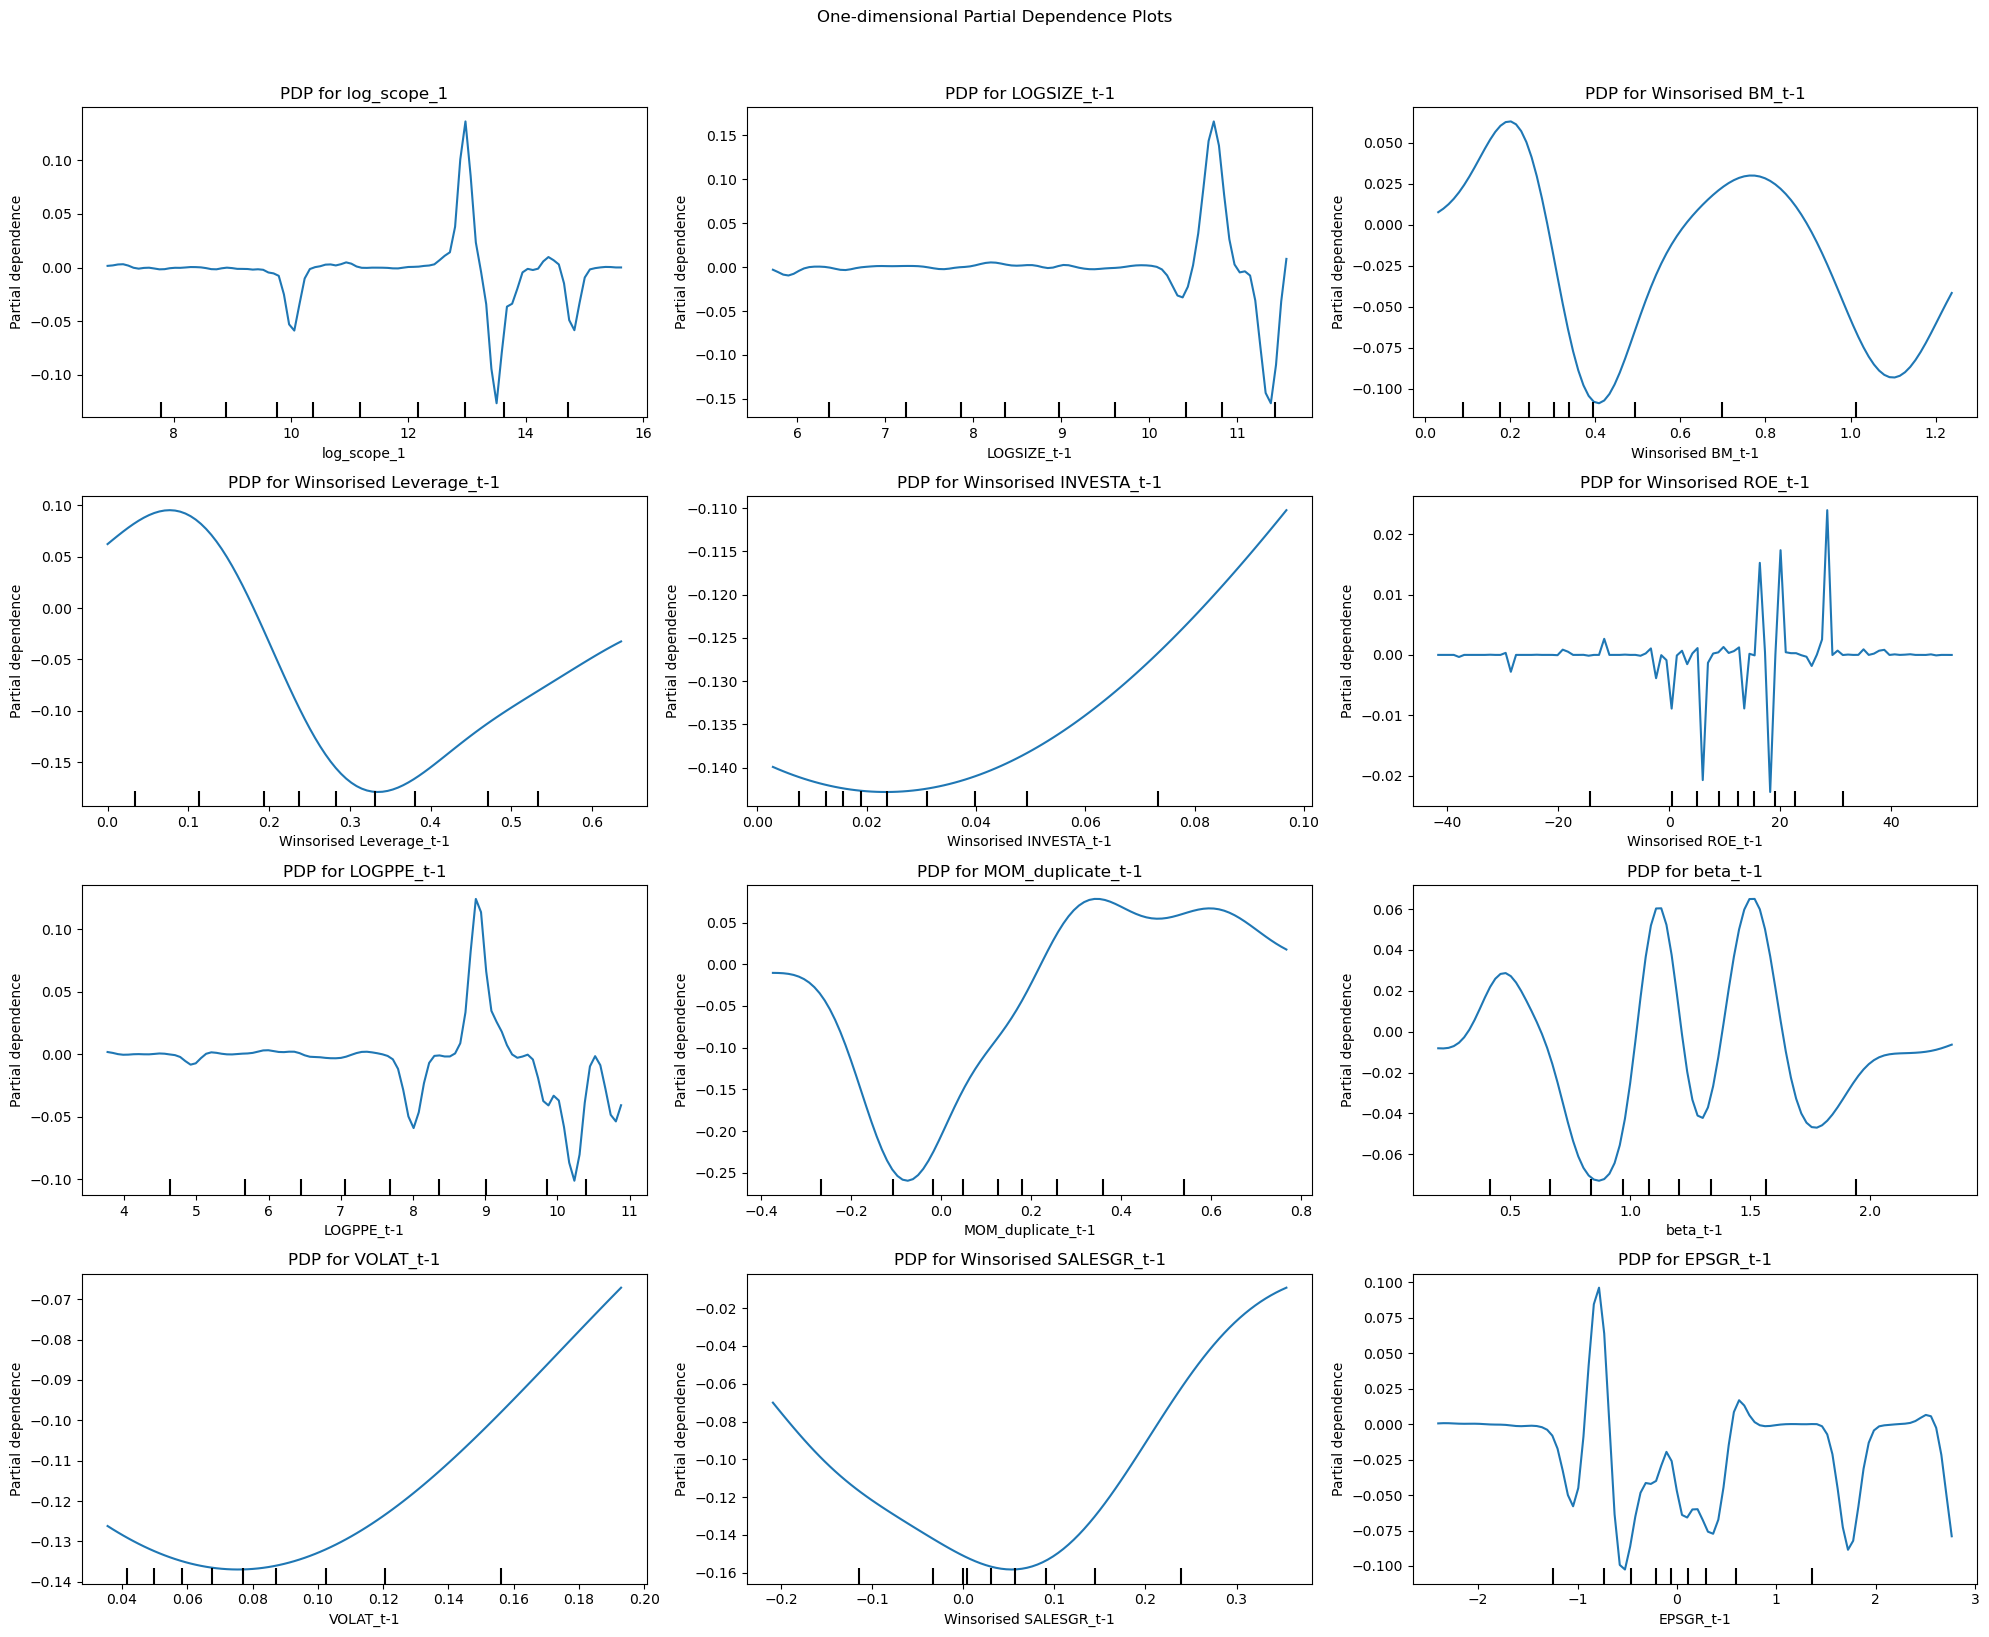

In [30]:
# Create the figure
fig1, axes1 = plt.subplots(nrows=4, ncols=3, figsize=(20, 16))

# List of features to plot
features_to_plot1 = ['Winsorised Carbon Intensity Scope 2', 'LOGSIZE_t-1', 'Winsorised BM_t-1', 'Winsorised Leverage_t-1',
                     'Winsorised INVESTA_t-1', 'Winsorised ROE_t-1', 'LOGPPE_t-1', 'MOM_duplicate_t-1',
                     'beta_t-1', 'VOLAT_t-1', 'Winsorised SALESGR_t-1', 'EPSGR_t-1']

# Draw PDP for each feature
for i, feature in enumerate(features_to_plot1):
    row = i // 3
    col = i % 3
    display = PartialDependenceDisplay.from_estimator(
        krls_optimized1,
        X_test1,
        features=[feature],
        kind='average',
        ax=axes1[row, col]
    )
    axes1[row, col].set_title(f'PDP for {feature}')
    axes1[row, col].set_xlabel(feature)
    axes1[row, col].set_ylabel('Partial Dependence')

# Set the overall title
plt.suptitle('One-dimensional Partial Dependence Plots', y=1.02)
plt.tight_layout()

# Show the figure
plt.show()

Comparison of mean partial derivatives and coefficients of features:
                         Average_Derivative  Coefficient  Difference
log_scope_1                       -0.001688     0.100566   -0.102254
LOGSIZE_t-1                       -0.000070     0.433059   -0.433129
Winsorised BM_t-1                 -0.000256    -2.989533    2.989277
Winsorised Leverage_t-1           -0.000228    -2.137561    2.137333
Winsorised INVESTA_t-1            -0.000025    -2.827154    2.827130
Winsorised ROE_t-1                 0.000371     0.004752   -0.004382
LOGPPE_t-1                        -0.000232    -0.044204    0.043973
MOM_duplicate_t-1                 -0.059557    -1.045185    0.985628
beta_t-1                          -0.177288     0.404245   -0.581533
VOLAT_t-1                          0.246284    21.458789  -21.212505
Winsorised SALESGR_t-1            -0.361900    -0.285141   -0.076759
EPSGR_t-1                          0.001497    -0.056547    0.058044


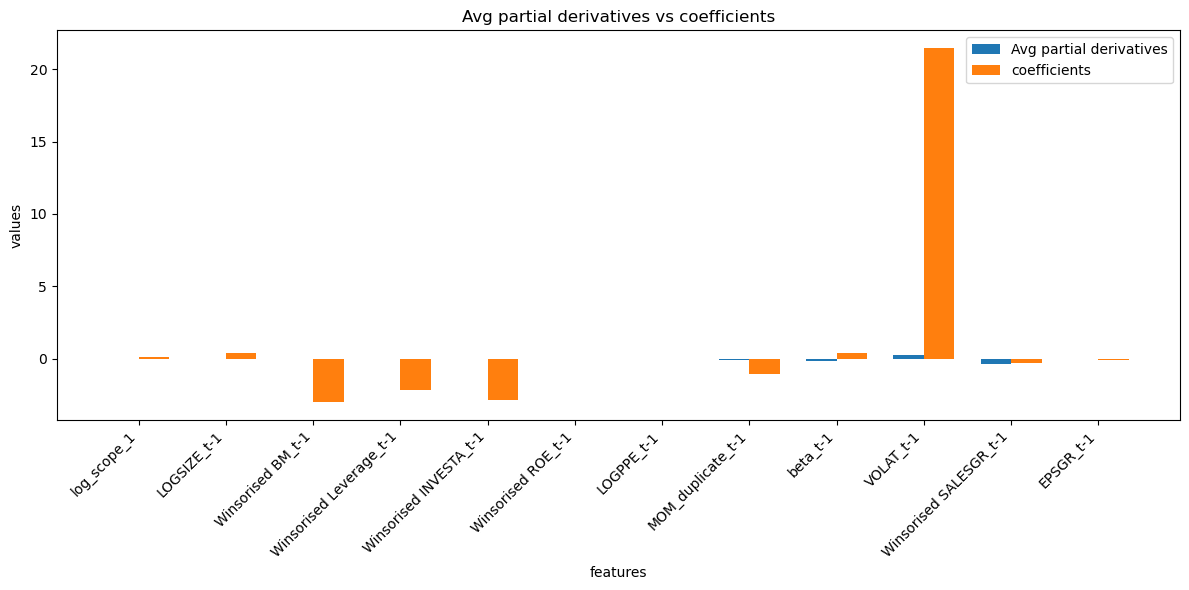

In [33]:
"""
Calculate average partial derivatives
"""

# Calculate average partial derivatives
feature_names1 = X_train1.columns

# Initialize empty dictionary
derivatives_with_labels1 = {}
average_derivatives1 = {}

for feature_index, feature_name in enumerate(feature_names1):
    # Calculate partial derivatives
    derivative = approximate_derivative(krls_optimized1, X_test1.to_numpy(), feature_index)
    
    # Calculate average value
    average_derivative = np.mean(derivative)
    
    # Store partial derivatives
    average_derivatives1[feature_name] = average_derivative
    derivatives_with_labels1[feature_name] = derivative
    
# Collect all average partial derivatives
average_derivatives_str1 = ", ".join([f"{feature_name}: {average_derivative:.4f}" for feature_name, average_derivative in average_derivatives1.items()])

# Use coefficients of linear regression
linear_coefficients1 = model_linear1.coef_

# Trans to DataFrame
df_derivatives1 = pd.DataFrame.from_dict(average_derivatives1, orient='index', columns=['Average_Derivative'])
df_derivatives1['Coefficient'] = linear_coefficients1
df_derivatives1['Difference'] = df_derivatives1['Average_Derivative'] - df_derivatives1['Coefficient']

# Print result
print("Comparison of mean partial derivatives and coefficients of features:")
print(df_derivatives1)

# Draw figure
features1 = df_derivatives1.index
average_derivative_values1 = df_derivatives1['Average_Derivative']
linear_coefficients_values1 = df_derivatives1['Coefficient']

x1 = np.arange(len(features1))
width = 0.35

fig2, ax2 = plt.subplots(figsize=(12, 6))  # Adjust the figure size
rects1 = ax2.bar(x1 - width/2, average_derivative_values1, width, label='Avg partial derivatives')
rects2 = ax2.bar(x1 + width/2, linear_coefficients_values1, width, label='coefficients')

ax2.set_xlabel('features')
ax2.set_ylabel('values')
ax2.set_title('Avg partial derivatives vs coefficients')
ax2.set_xticks(x1)
ax2.set_xticklabels(features1, rotation=45, ha='right')  # Rotate x-axis labels
ax2.legend()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()


In [ ]:
def add_interaction_terms(X, interaction_pairs):
    """
    Add interaction term to variable list
    """
    X_interacted = X.copy()
    for pair in interaction_pairs:
        new_column_name = f"interaction_{'_'.join(pair)}"
        X_interacted[new_column_name] = X_interacted[pair[0]] * X_interacted[pair[1]]
    return X_interacted

In [ ]:
"""Need to change selected_columns"""

# Prepare data
X_train1_copy1 = X_train1.copy()
y_train1_copy1 = y_train1.copy()

# list to collect scores
interaction_scores1 = []

# Find all possible interactions
selected_columns1 = ['Winsorised Carbon Intensity Scope 2', 'Winsorised BM_t-1', 'Winsorised Leverage_t-1', 'Winsorised INVESTA_t-1','MOM_duplicate_t-1','VOLAT_t-1']
all_pairs1 = list(combinations(selected_columns1, 2))

for pair in all_pairs1:
    # Add interaction term
    X_train_interacted1 = add_interaction_terms(X_train1_copy1, [pair])
    
    # Use cross validation to evaluate
    score1 = np.mean(cross_val_score(krls_optimized1, X_train_interacted1, y_train1_copy1, cv=5, scoring='r2'))
    
    # store the interaction term and corresponding score
    interaction_scores1.append((pair, score1))

# Order by scores
sorted_interactions1 = sorted(interaction_scores1, key=lambda x: x[1], reverse=True)

# Choose top N interaction terms
N = 5  
best_interactions1 = sorted_interactions1[:N]

# Print top N interaction terms
print(f"Top {N} interactions:")
for interaction, score in best_interactions1:
    print(f"Interaction: {interaction}, Mean Score: {score}")

In [ ]:
# prepare data
X_train1_copy2 = X_train1.copy()
y_train1_copy2 = y_train1.copy()

threshold = 0.001
previous_best_mse1 = np.inf
N1 = 5
selected_interactions1 = []

# Iterative process
for iteration in range(N1):
    best_score1 = -np.inf
    best_interaction1 = None
    best_mse1 = np.inf
    best_r2_1 = -np.inf
    
    # interactions between original features
    all_pairs11 = list(combinations(selected_columns1, 2))
    
    for pair in all_pairs11:
        # Create new data
        X_train_interacted = X_train1_copy2.copy()
        interaction_name1 = "_".join(pair) + "_interaction"
        X_train_interacted[interaction_name1] = X_train_interacted[pair[0]] * X_train_interacted[pair[1]]
        
        # Use cross-validation to evaluate
        scores1 = cross_validate(krls_optimized1, X_train_interacted, y_train1_copy2, cv=5, scoring=('neg_mean_squared_error', 'r2'))
        current_mse1 = -np.mean(scores1['test_neg_mean_squared_error'])
        current_r2_1 = np.mean(scores1['test_r2'])
        
        if current_mse1 < best_mse1:
            best_mse1 = current_mse1
            best_interaction1 = pair
            best_interaction_name1 = interaction_name1
            best_r2_1 = current_r2_1

    if previous_best_mse1 - best_mse1 < threshold:
        print("MSE improvement is below the threshold. Stopping iteration.")
        break
    else:
        previous_best_mse1 = best_mse1
        if best_interaction1:
            selected_interactions1.append(best_interaction1)
            print(f"Iteration {iteration+1}: Selected interaction: {best_interaction1}, Mean MSE: {best_mse1}, Mean R2: {best_r2_1}")
            # renew the dataset
            X_train1_copy2[best_interaction_name1] = X_train1_copy2[best_interaction1[0]] * X_train1_copy2[best_interaction1[1]]
        else:
            print("No further improvement.")
            break

In [ ]:
# Define the interaction pairs
interaction_pairs = [
    ('LOGSIZE_t-1', 'MOM_duplicate_t-1'),
    ('LOGSIZE_t-1', 'beta_t-1'),
    ('LOGSIZE_t-1', 'VOLAT_t-1')
]

# Number of interaction pairs
n_interactions = len(interaction_pairs)

# Create subplots
fig3, ax3 = plt.subplots(nrows=n_interactions, figsize=(8, 4 * n_interactions))  # Adjust figsize as needed

# Create Partial Dependence Plots
display2 = PartialDependenceDisplay.from_estimator(
    krls_optimized1, 
    X_test1, 
    interaction_pairs, 
    ax=ax3
)

# Adjust layout
plt.subplots_adjust(top=0.9, hspace=0.3)  # Adjust hspace for vertical spacing
plt.show()